# Criteria to select genes and cells

- eliminate proliferating cell types (not interested in proliferating cell states)
- remake the gene lists based on the DE new criteria (wilcox, pval threshold, sorted by logfc)

In [1]:
import os,sys
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.sparse
import anndata
import seaborn as sns
#import scvelo as scv

#import milopy.core as milo
#import milopy.plot as milopl


In [2]:
sc.set_figure_params(dpi=80, dpi_save=600) # Makes it more visible

In [3]:
tmpfile = '../h5ad_files/MYELOID_lineage_wilcox_ALL_tmp.h5ad'

In [4]:
adata = sc.read_h5ad('../h5ad_files/myeloid.h5ad')
adata

AnnData object with n_obs × n_vars = 51552 × 36503
    obs: 'donor_id', 'Predicted_labels_CellTypist', 'Majority_voting_CellTypist', 'Manually_curated_celltype', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'gene_symbols', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    uns: 'cell_type_ontology_term_id_colors', 'default_embedding', 'development_stage_ontology_term_id_colors', 'schema_version', 'sex_ontology_term_id_colors', 'title'
    obsm: 'X_umap'

In [5]:
adata.raw

In [6]:
adata = adata.raw.to_adata()

In [7]:
adata.X.max()

17104.0

In [8]:
adata.obs["Manually_curated_celltype"].cat.categories

Index(['Alveolar macrophages', 'Classical monocytes', 'Cycling', 'DC1', 'DC2',
       'Erythrophagocytic macrophages', 'Intermediate macrophages',
       'Intestinal macrophages', 'MNP/T doublets', 'Nonclassical monocytes',
       'migDC'],
      dtype='object')

In [9]:
adata = adata[adata.obs['Manually_curated_celltype'].isin(['Alveolar macrophages', 
                                                           'Classical monocytes',# 'Cycling',
                                                           'DC1', 'DC2',
                                                           'Erythrophagocytic macrophages',
                                                           'Intermediate macrophages',
                                                           'Intestinal macrophages',# 'MNP/T doublets',
                                                           'Nonclassical monocytes',
                                                           'migDC'])]

/home/irepan/anaconda3/envs/pyscenic/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


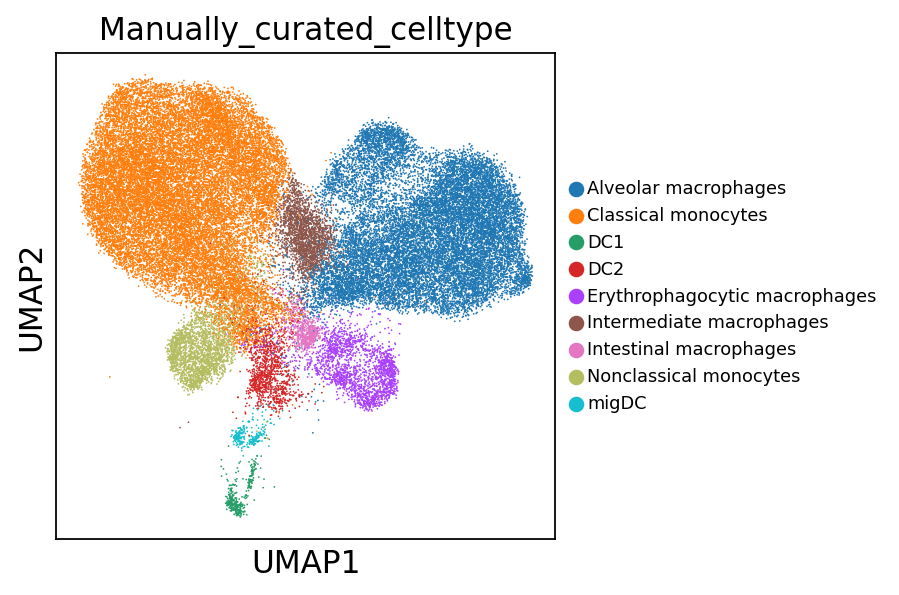

In [10]:
sc.pl.umap(adata, color="Manually_curated_celltype",#save= "Lymphoid.png",
           legend_fontoutline=1, legend_fontsize=8)

<AxesSubplot:title={'center':'adata'}>

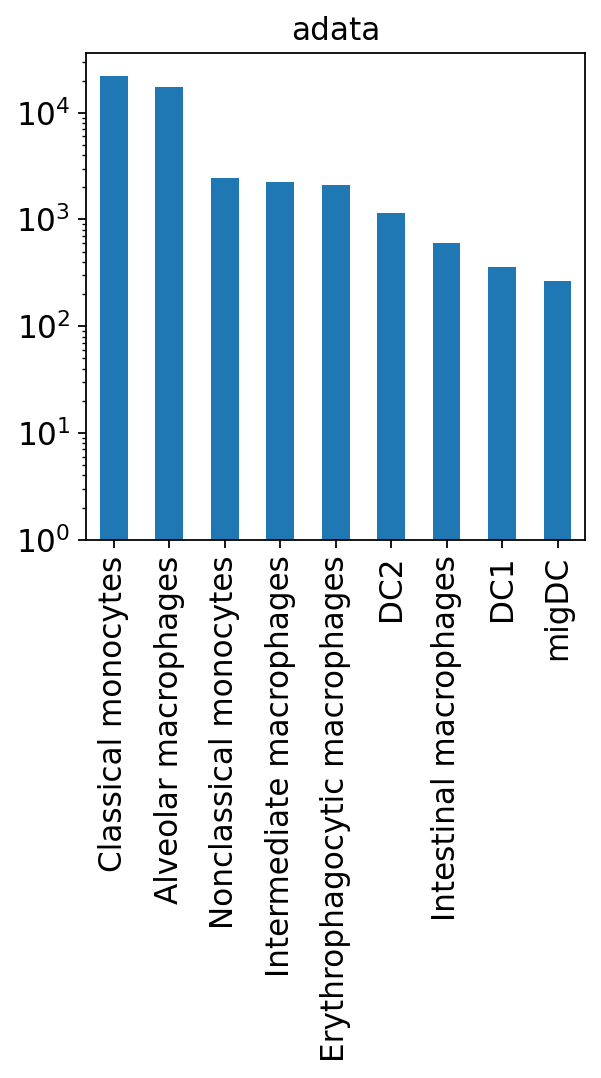

In [11]:
adata.obs['Manually_curated_celltype'].value_counts().plot(kind='bar', log="y",
                                                           grid=False, title='adata')

In [12]:
target_cells = 2000

adatas = [adata[adata.obs['Manually_curated_celltype'].isin([clust])] for clust in adata.obs['Manually_curated_celltype'].cat.categories]

for dat in adatas:
    if dat.n_obs > target_cells:
        sc.pp.subsample(dat, n_obs=target_cells, random_state=0)

adata_sample1 = adatas[0].concatenate(*adatas[1:])

/home/irepan/anaconda3/envs/pyscenic/lib/python3.7/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [13]:
adata_sample1

AnnData object with n_obs × n_vars = 12364 × 36503
    obs: 'donor_id', 'Predicted_labels_CellTypist', 'Majority_voting_CellTypist', 'Manually_curated_celltype', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'batch'
    var: 'feature_name', 'feature_reference', 'feature_biotype'
    obsm: 'X_umap'

<AxesSubplot:title={'center':'sampled cells'}>

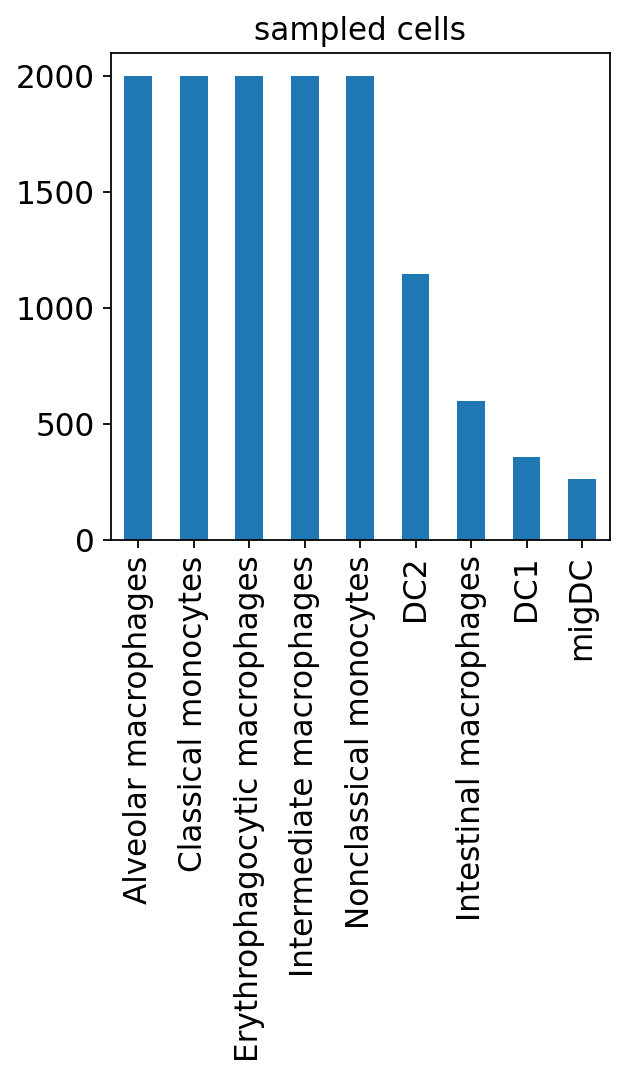

In [14]:
adata_sample1.obs['Manually_curated_celltype'].value_counts().plot(kind='bar', #log="y",
                                                                   grid=False, title='sampled cells')

In [15]:
adata = adata_sample1

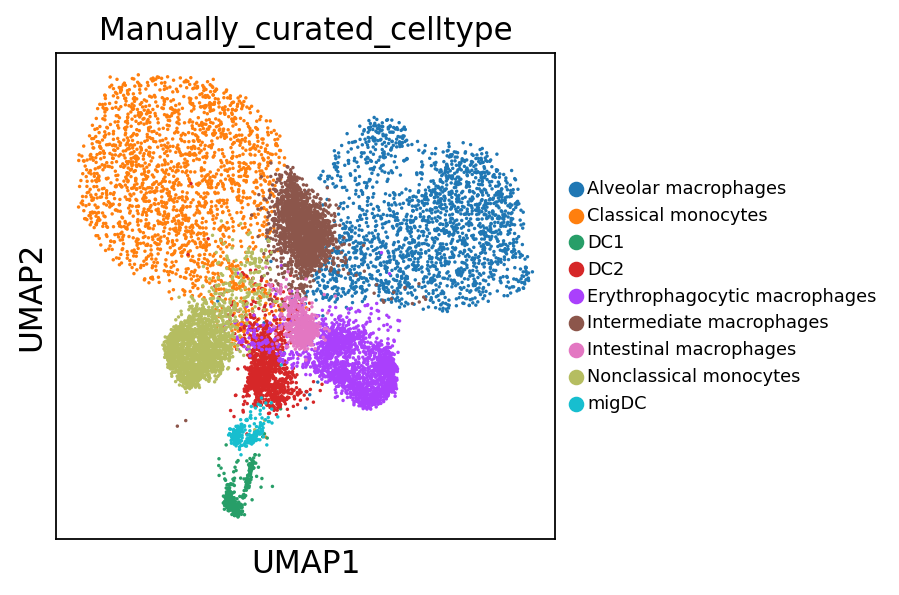

In [16]:
sc.pl.umap(adata, color="Manually_curated_celltype",#save= "Lymphoid.png",
           legend_fontoutline=1, legend_fontsize=8)

In [17]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=10e4)
sc.pp.log1p(adata)

In [18]:
#pip install --user scikit-misc
#sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor= "seurat_v3" )min_mean :
sc.settings.verbosity = 4
sc.pp.highly_variable_genes(adata, min_mean=0.3, max_mean=5)

extracting highly variable genes
    Gene indices [32322] fell into a single bin: their normalized dispersion was set to 1.
    Decreasing `n_bins` will likely avoid this effect.
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


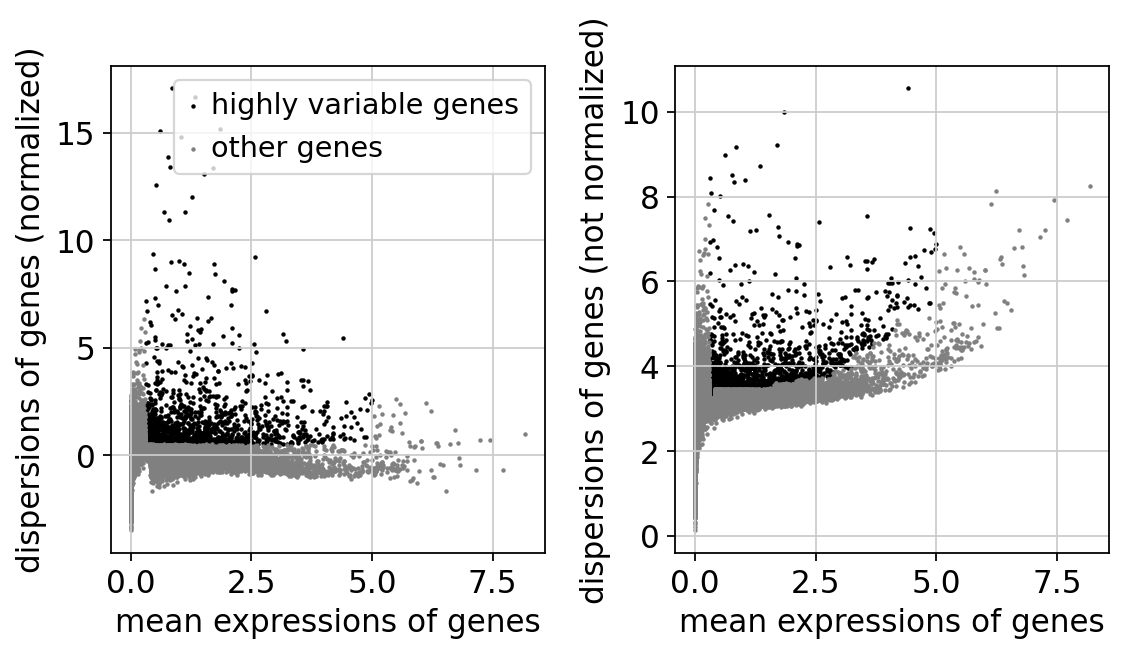

In [19]:
sc.pl.highly_variable_genes(adata)

normalizing counts per cell
    finished (0:00:00)


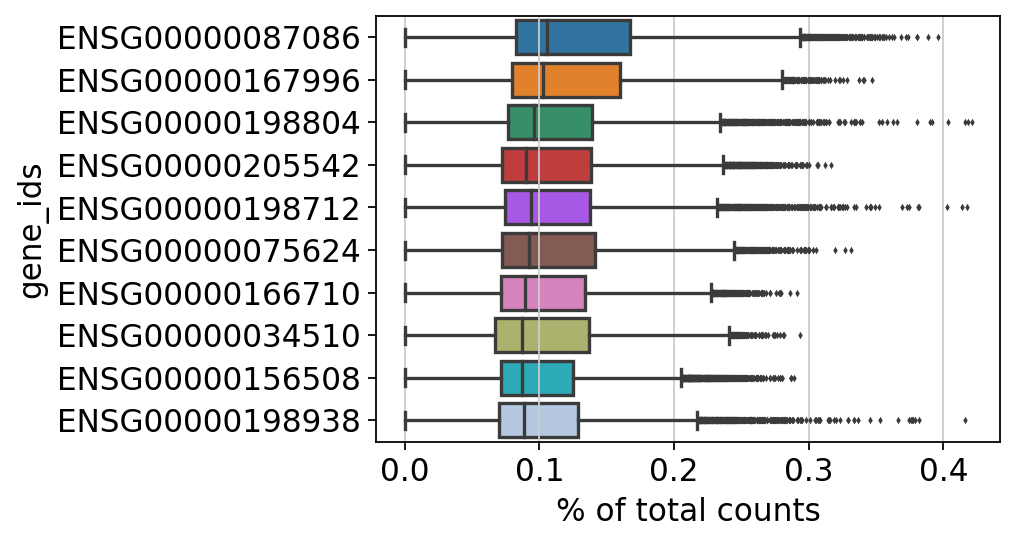

In [20]:
sc.pl.highest_expr_genes(adata, n_top=10, show=True)

ranking genes
    consider 'Manually_curated_celltype' groups:
    with sizes: [2000 2000  356 1147 2000 2000  599 2000  262]
    finished: added to `.uns['wilcoxon']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:18)


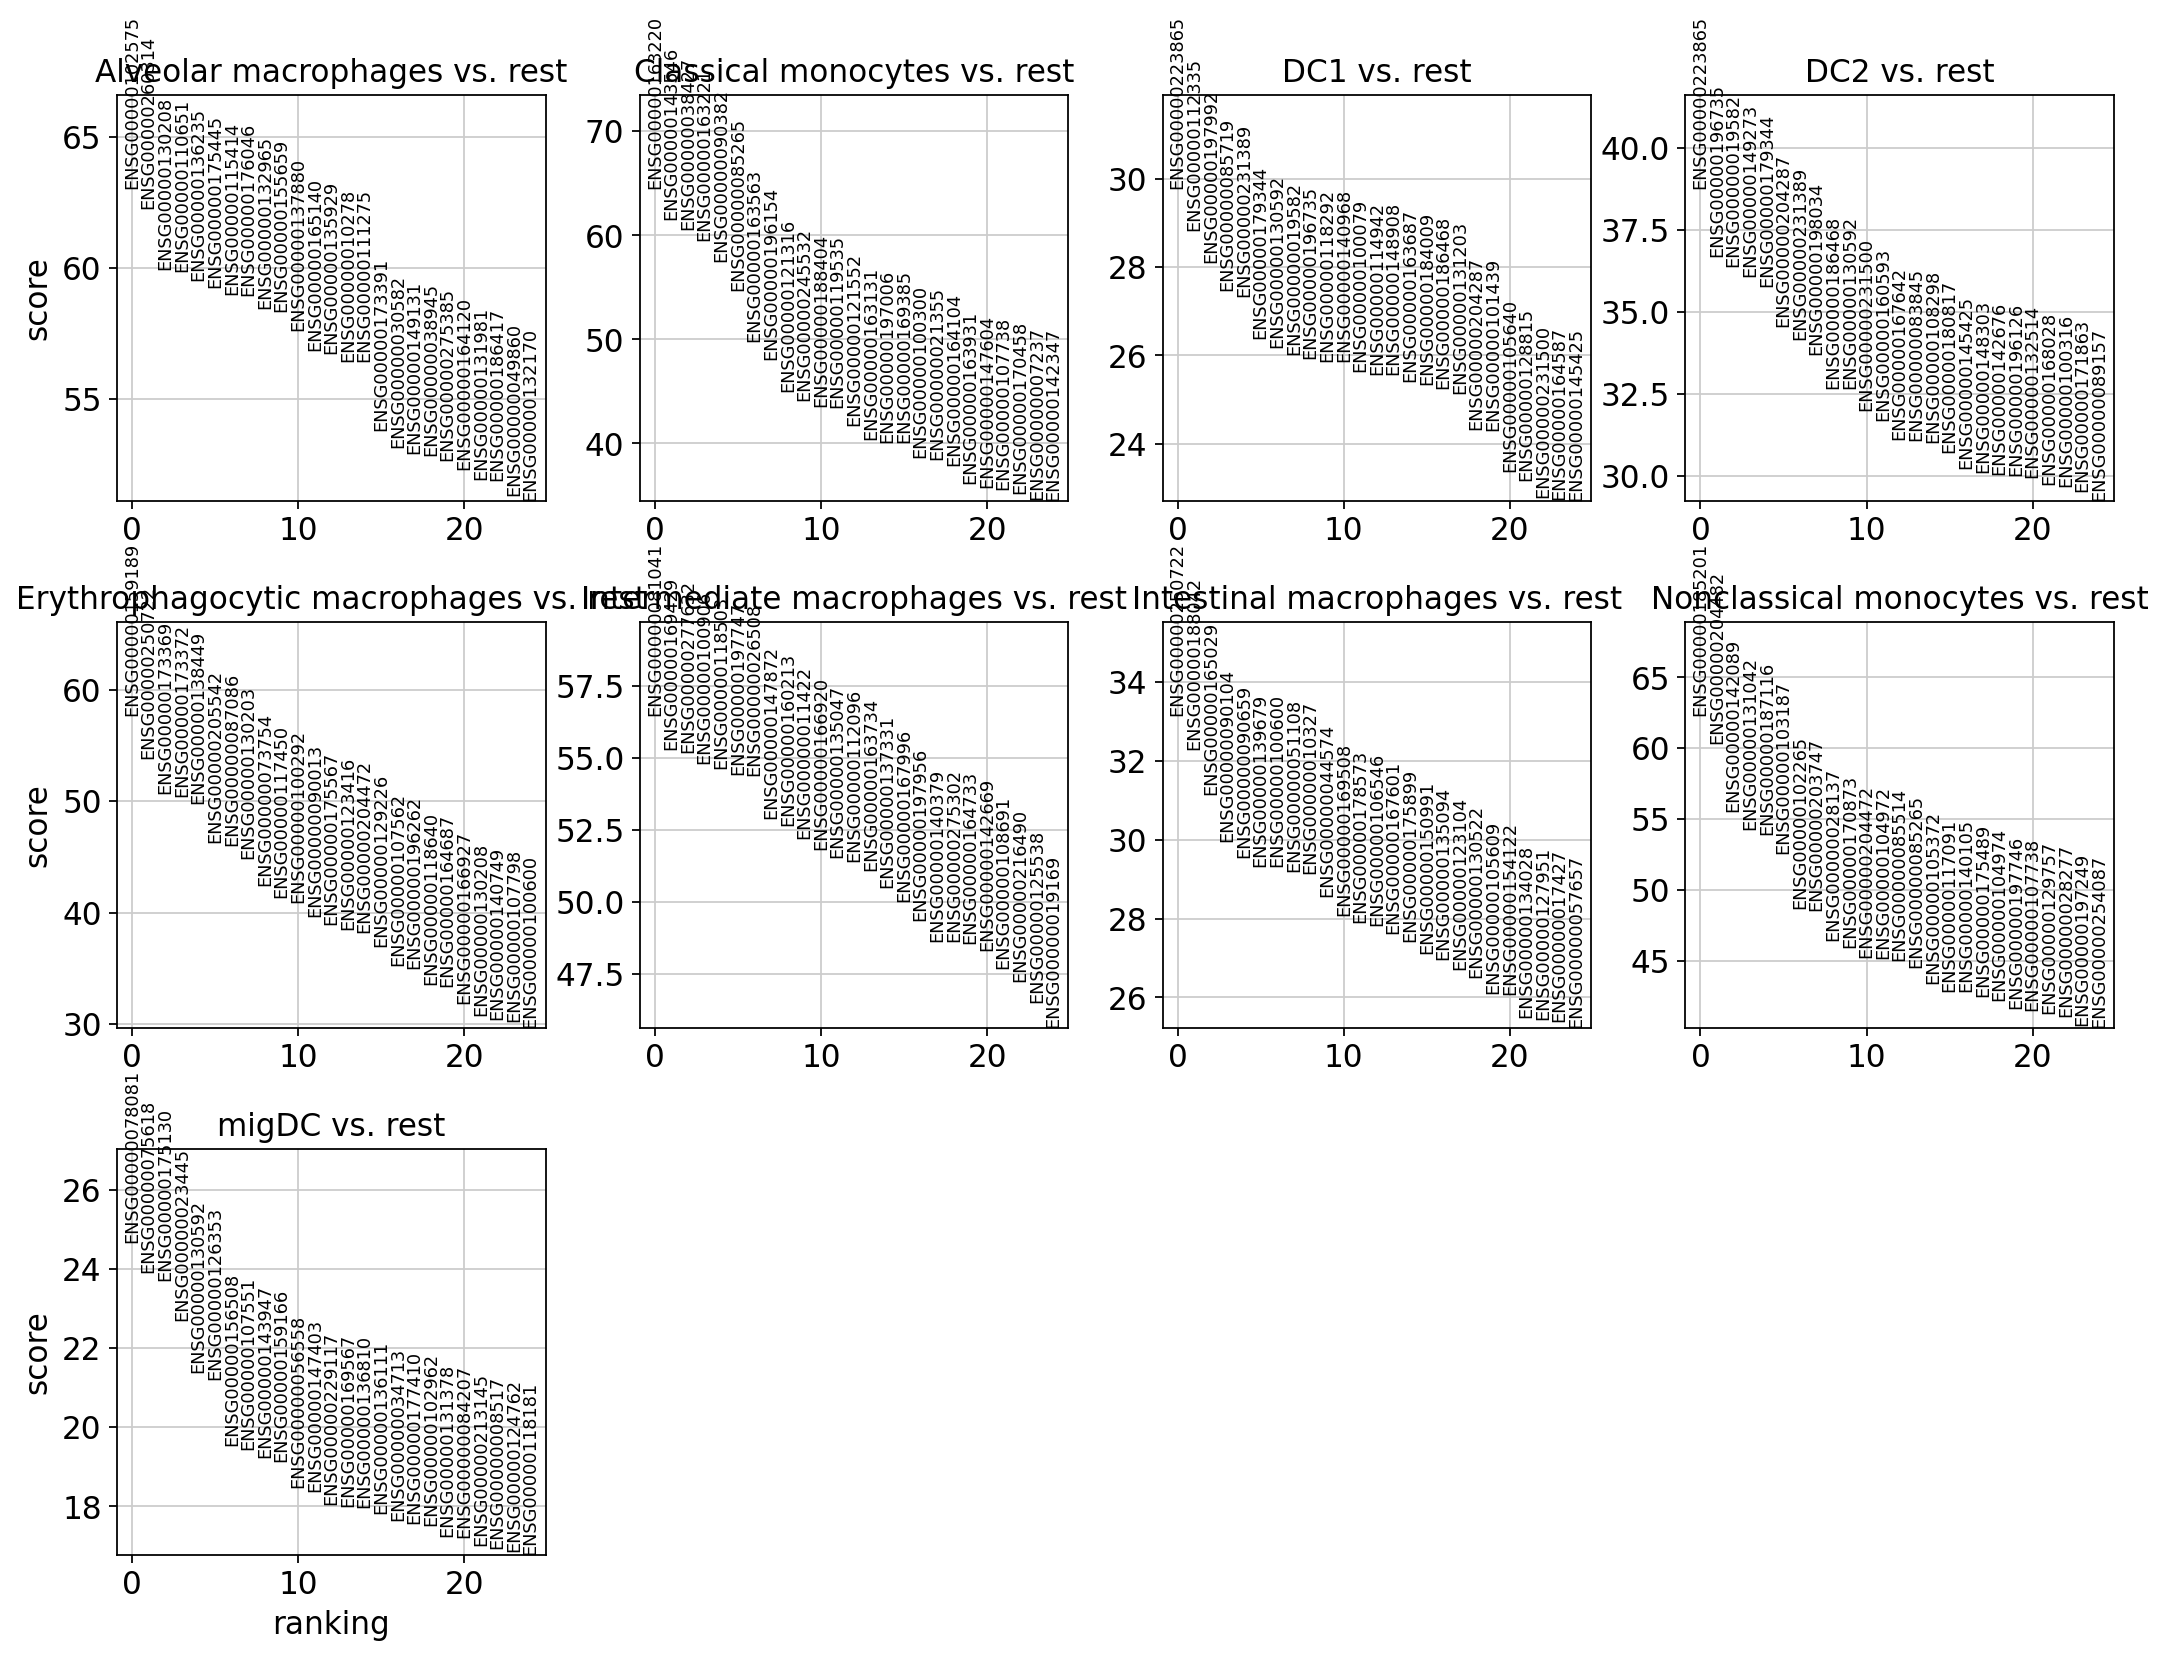

In [21]:
sc.tl.rank_genes_groups(adata, groupby= 'Manually_curated_celltype', method='wilcoxon', key_added= "wilcoxon")
sc.pl.rank_genes_groups(adata,  n_genes=25,  sharey=False, key= "wilcoxon")

In [22]:
adata.write(tmpfile)

## Read prepocessed data

In [4]:
adata = sc.read_h5ad(tmpfile)

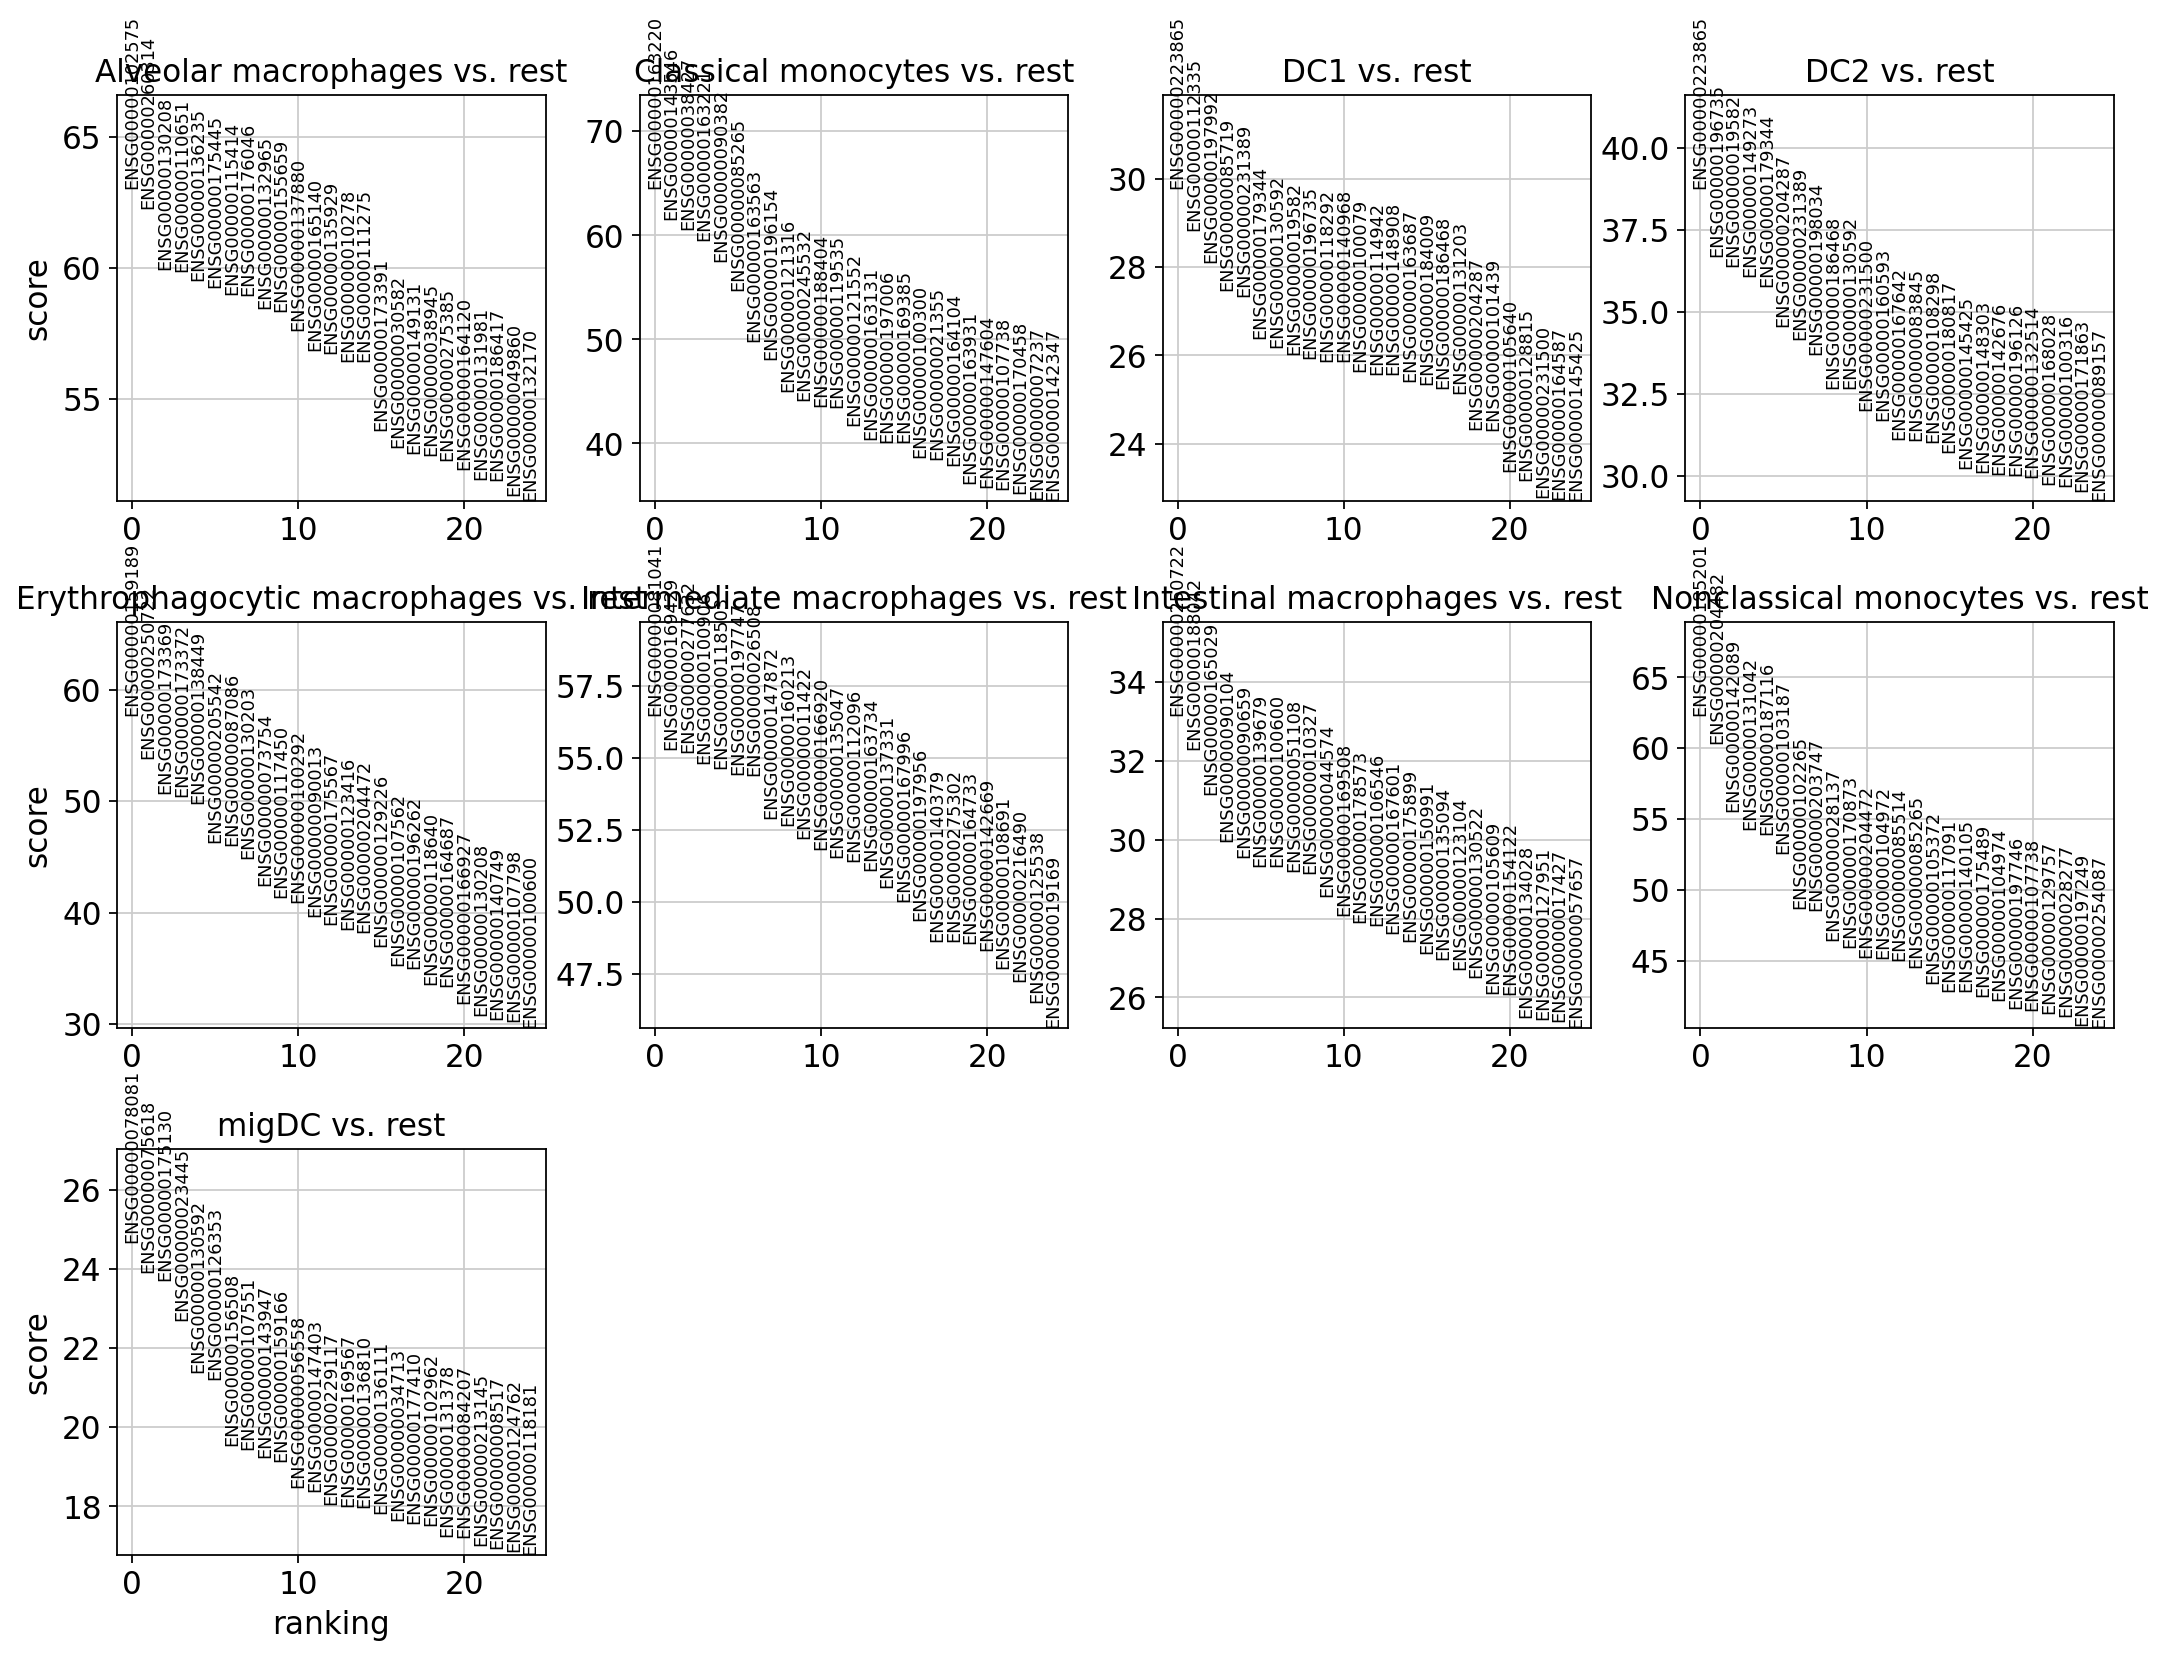

In [5]:
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key = "wilcoxon")

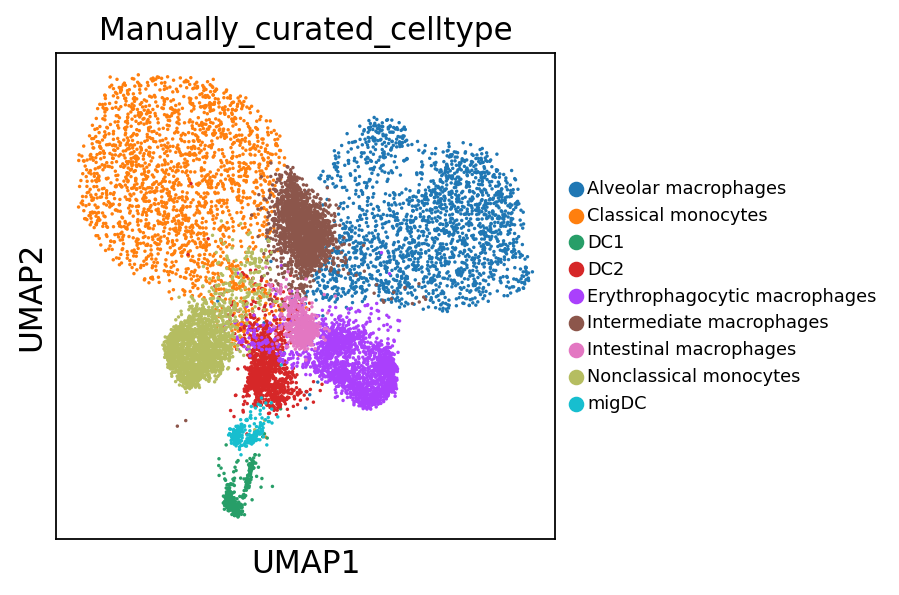

In [6]:
sc.pl.umap(adata, color="Manually_curated_celltype",#save= "Lymphoid.png",
           legend_fontoutline=1, legend_fontsize=8)

## Loop to produce the lists of Myeloid lineages

In [7]:
Subtypes = adata.obs['Manually_curated_celltype'].unique()
Subtypes

['Alveolar macrophages', 'Classical monocytes', 'DC1', 'DC2', 'Erythrophagocytic macrophages', 'Intermediate macrophages', 'Intestinal macrophages', 'Nonclassical monocytes', 'migDC']
Categories (9, object): ['Alveolar macrophages', 'Classical monocytes', 'DC1', 'DC2', ..., 'Intermediate macrophages', 'Intestinal macrophages', 'Nonclassical monocytes', 'migDC']

In [8]:
for i in range(0,len(Subtypes)):
    print(i, Subtypes[i])

0 Alveolar macrophages
1 Classical monocytes
2 DC1
3 DC2
4 Erythrophagocytic macrophages
5 Intermediate macrophages
6 Intestinal macrophages
7 Nonclassical monocytes
8 migDC


### Marker genes for each Subtype

In [9]:
Markers = [[]]*len(Subtypes)

for i in range(0,len(Subtypes)):
    print(i, Subtypes[i])
    m = sc.get.rank_genes_groups_df(adata, group=Subtypes[i],
                                    key='wilcoxon', pval_cutoff=0.0001,
                                    log2fc_min=1)
    m = m.sort_values("logfoldchanges", ascending=False)
    m.reset_index(drop=True, inplace=True)
    Markers[i] = m

0 Alveolar macrophages
1 Classical monocytes
2 DC1
3 DC2
4 Erythrophagocytic macrophages
5 Intermediate macrophages
6 Intestinal macrophages
7 Nonclassical monocytes
8 migDC


In [10]:
Markers[0]["names"][0:8]

0    ENSG00000258826
1    ENSG00000115648
2    ENSG00000241213
3    ENSG00000135917
4    ENSG00000167588
5    ENSG00000185565
6    ENSG00000056736
7    ENSG00000232884
Name: names, dtype: object

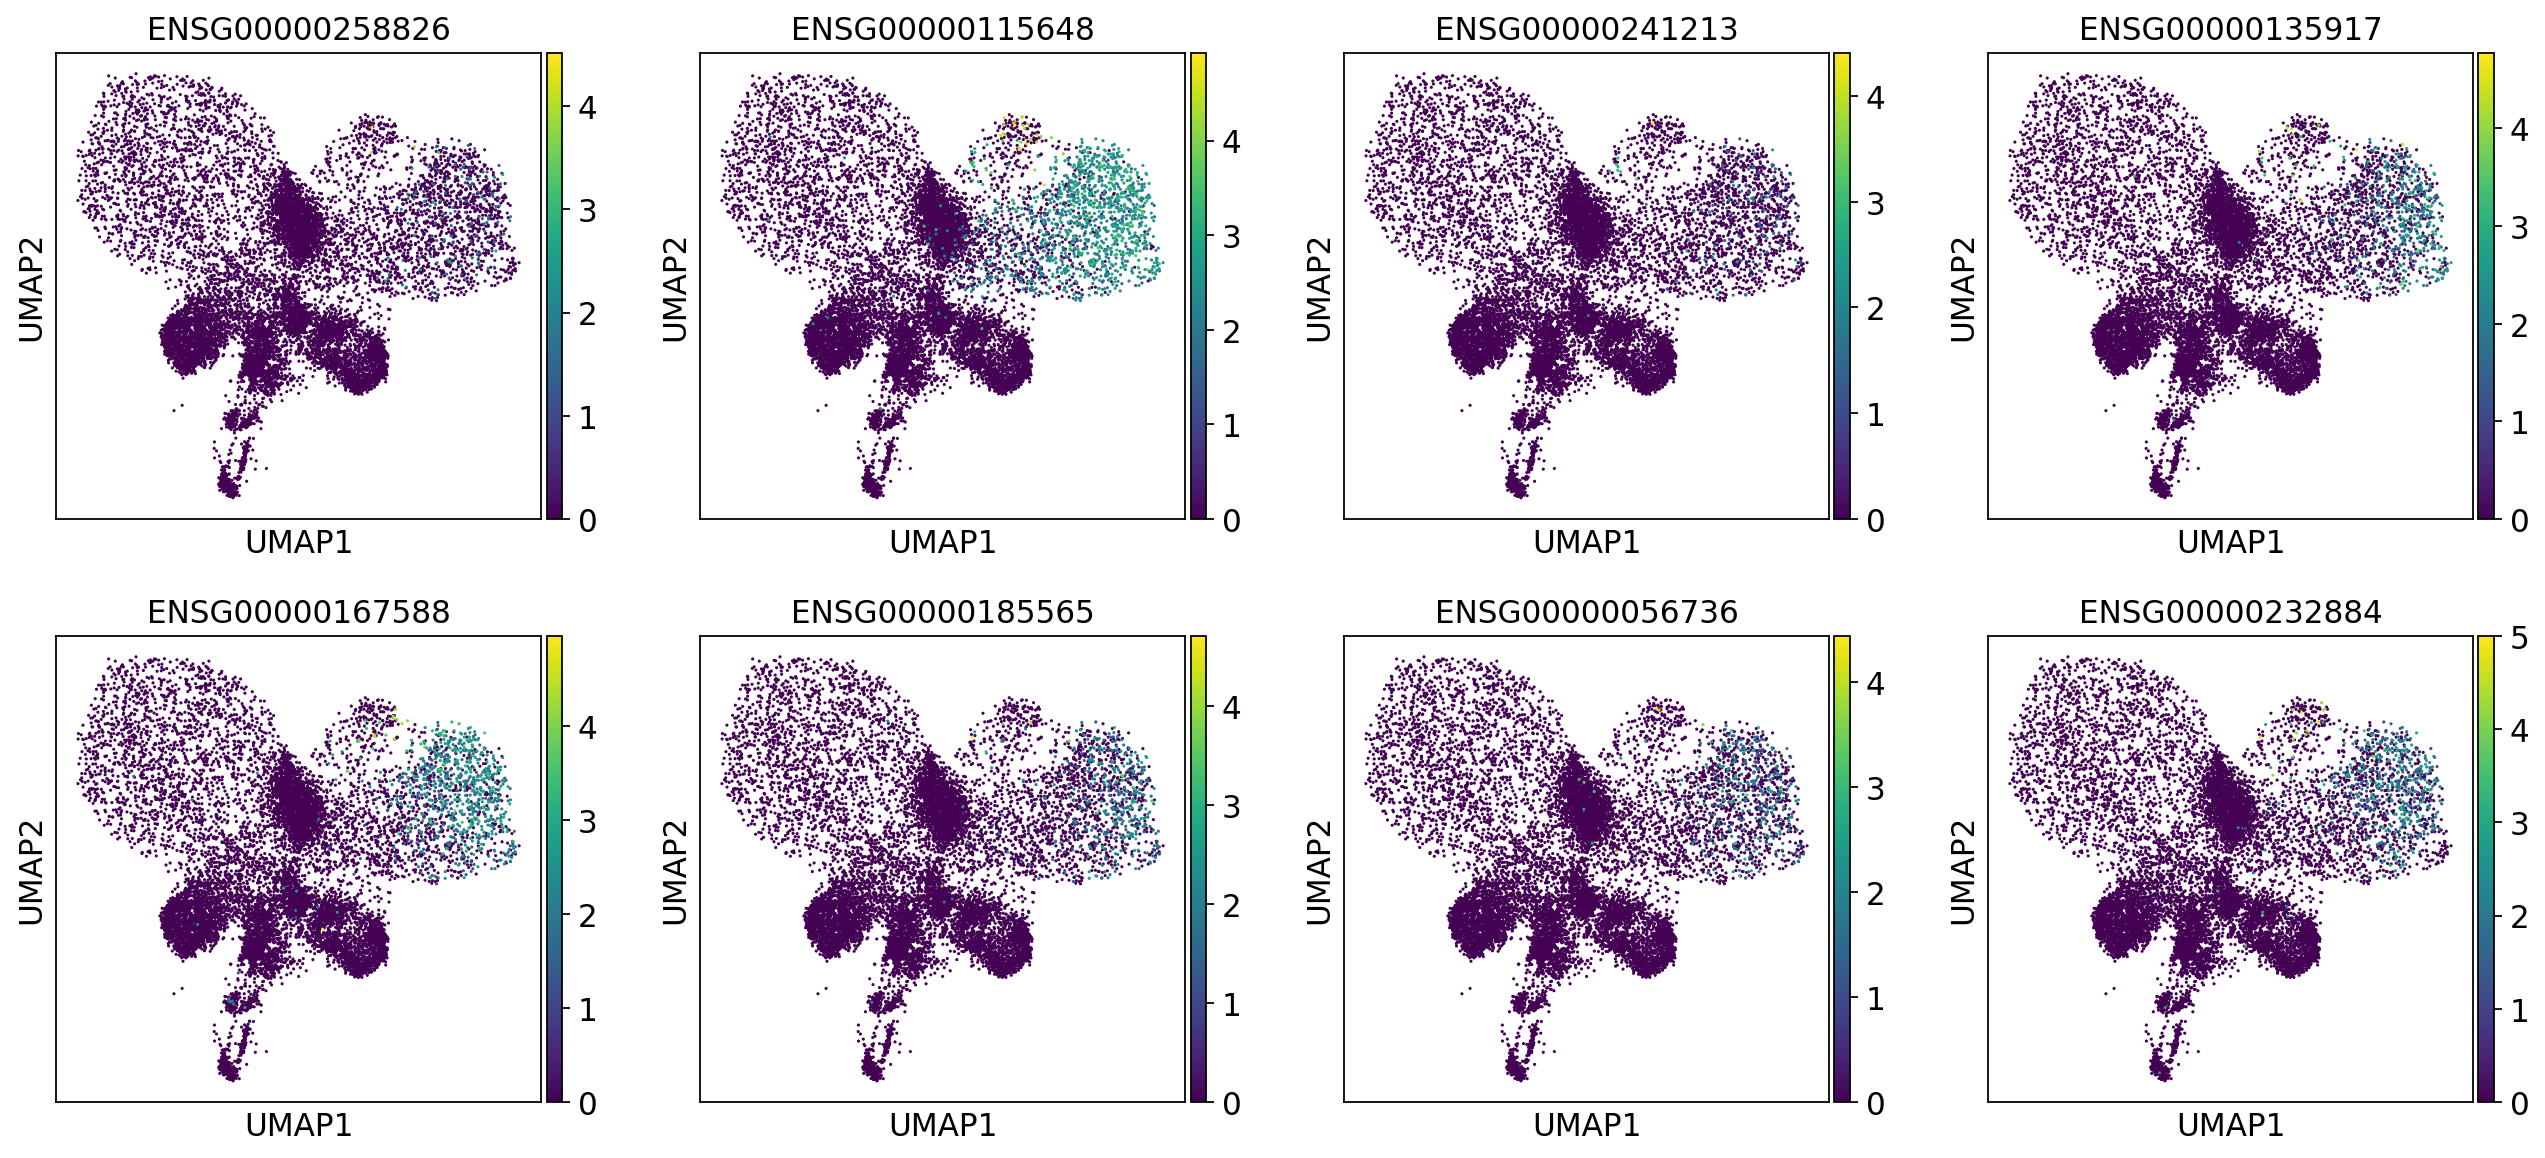

In [11]:
sc.pl.umap(adata, color= Markers[0]["names"][0:8], size=8 ) # top

##### Get names of 500 top markers (if possible) for each Subtype

In [12]:
#pip install upsetplot
from upsetplot import from_contents
from upsetplot import UpSet

In [13]:
Sets = [[]]*len(Subtypes)
CompleteSets = [[]]*len(Subtypes)

for i in range(0,len(Subtypes)):
    CompleteSets[i] = Markers[i]['names']
    n = len(Markers[i])
    #print(i, Subtypes[i], n)
    if n > 500 :
        #print("yes")
        Sets[i] = Markers[i].loc[0:499,'names']
    else :
        #print("no")
        Sets[i] = Markers[i].loc[0:n-1,'names']

In [14]:
Dict_markers =  {}
CompleteDict_markers =  {}

for i in range(0,len(Subtypes)):
    Dict_markers[Subtypes[i]] = Sets[i]
    CompleteDict_markers[Subtypes[i]] = CompleteSets[i]

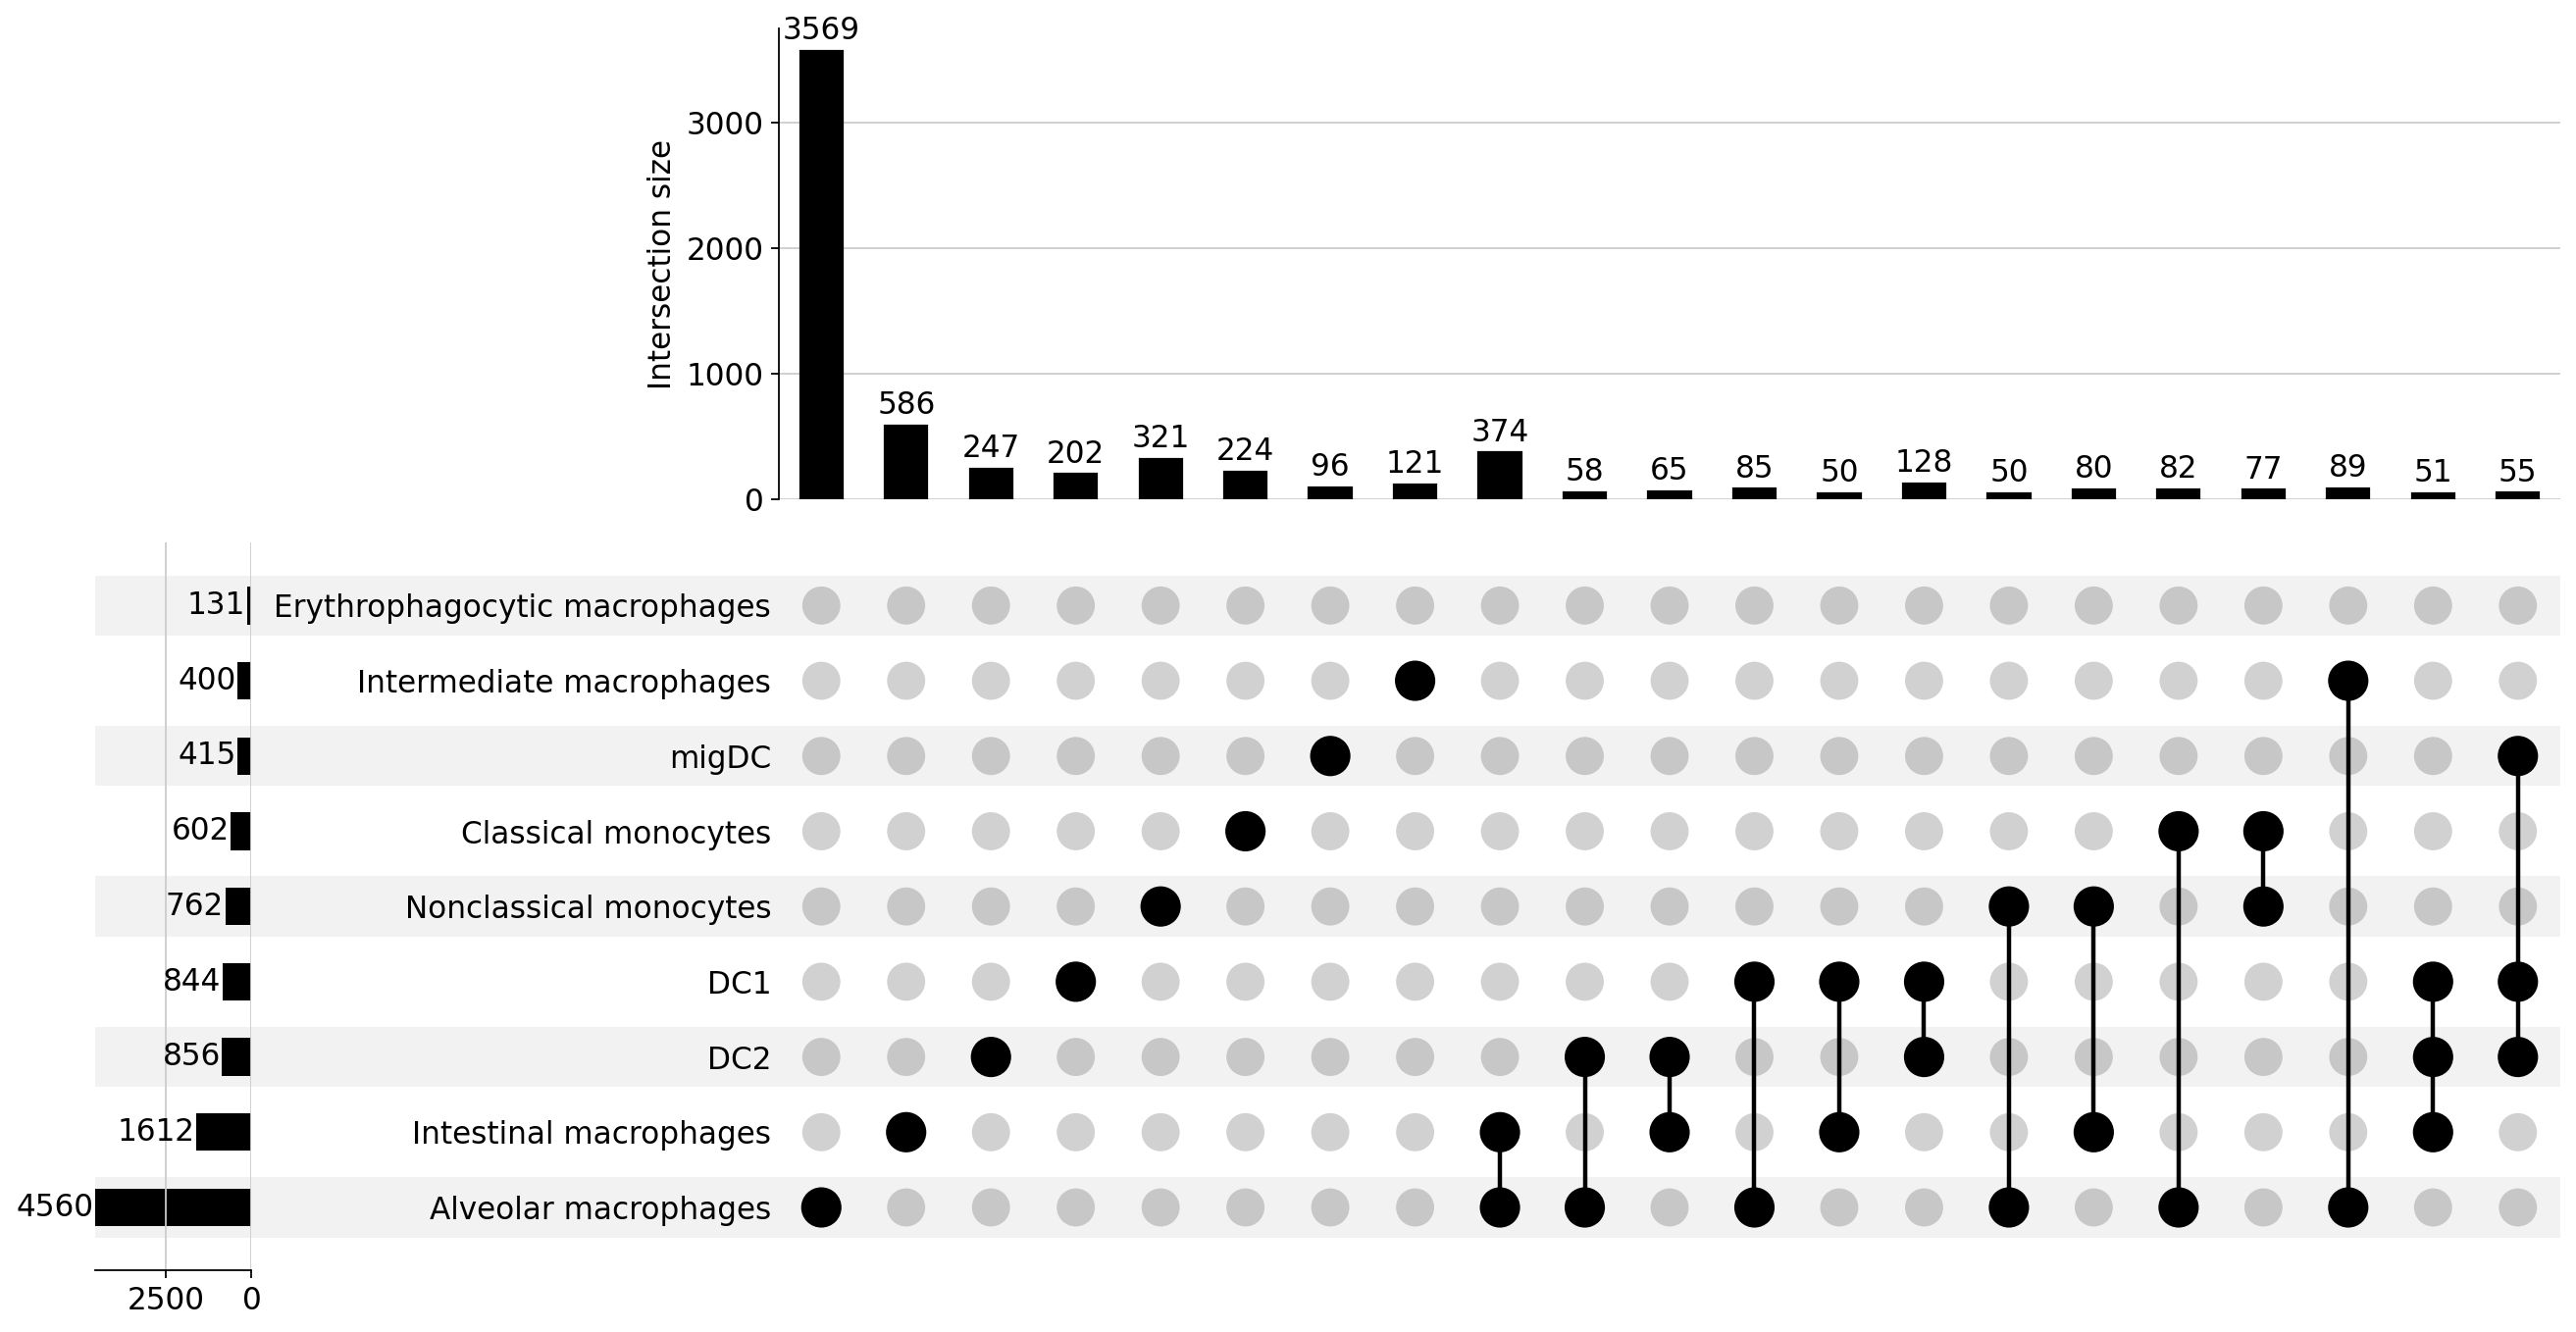

In [15]:
CT_markers = from_contents(CompleteDict_markers)

plt = UpSet(CT_markers, min_subset_size=50, subset_size='count',element_size=50,  show_counts=True).plot()

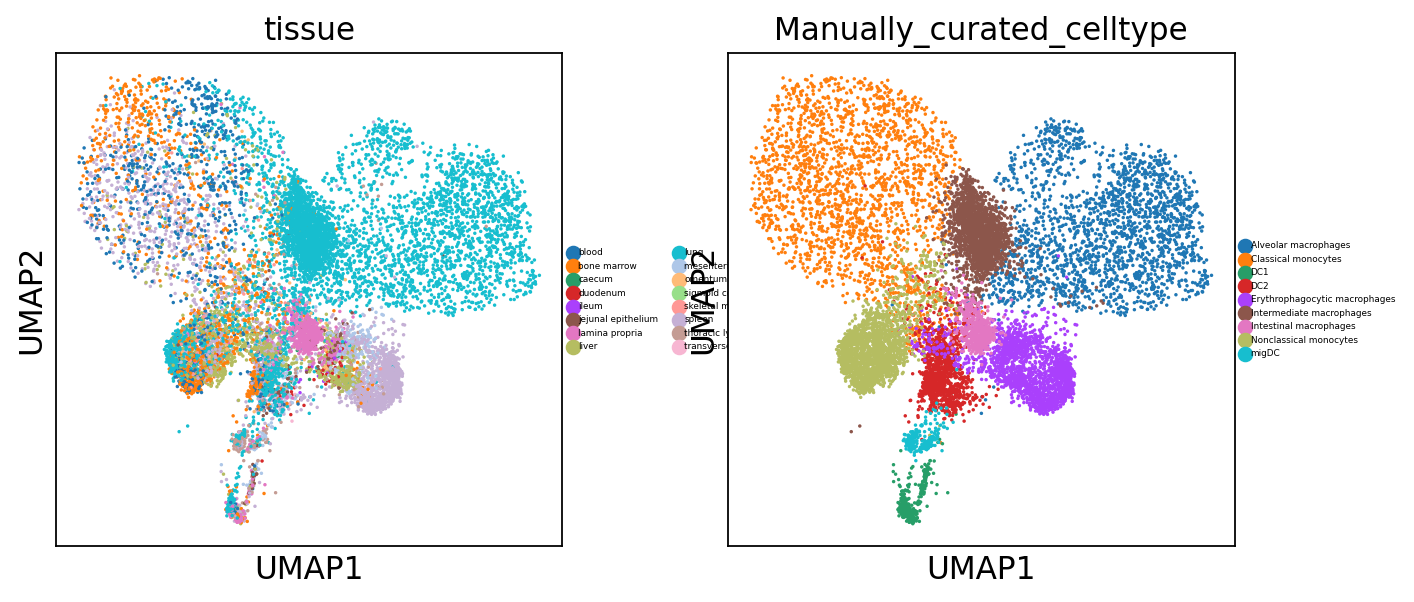

In [16]:
sc.pl.umap(adata, color=["tissue",'Manually_curated_celltype'] ,#save= "Lymphoid.png",
           legend_fontoutline=1, legend_fontsize=4)

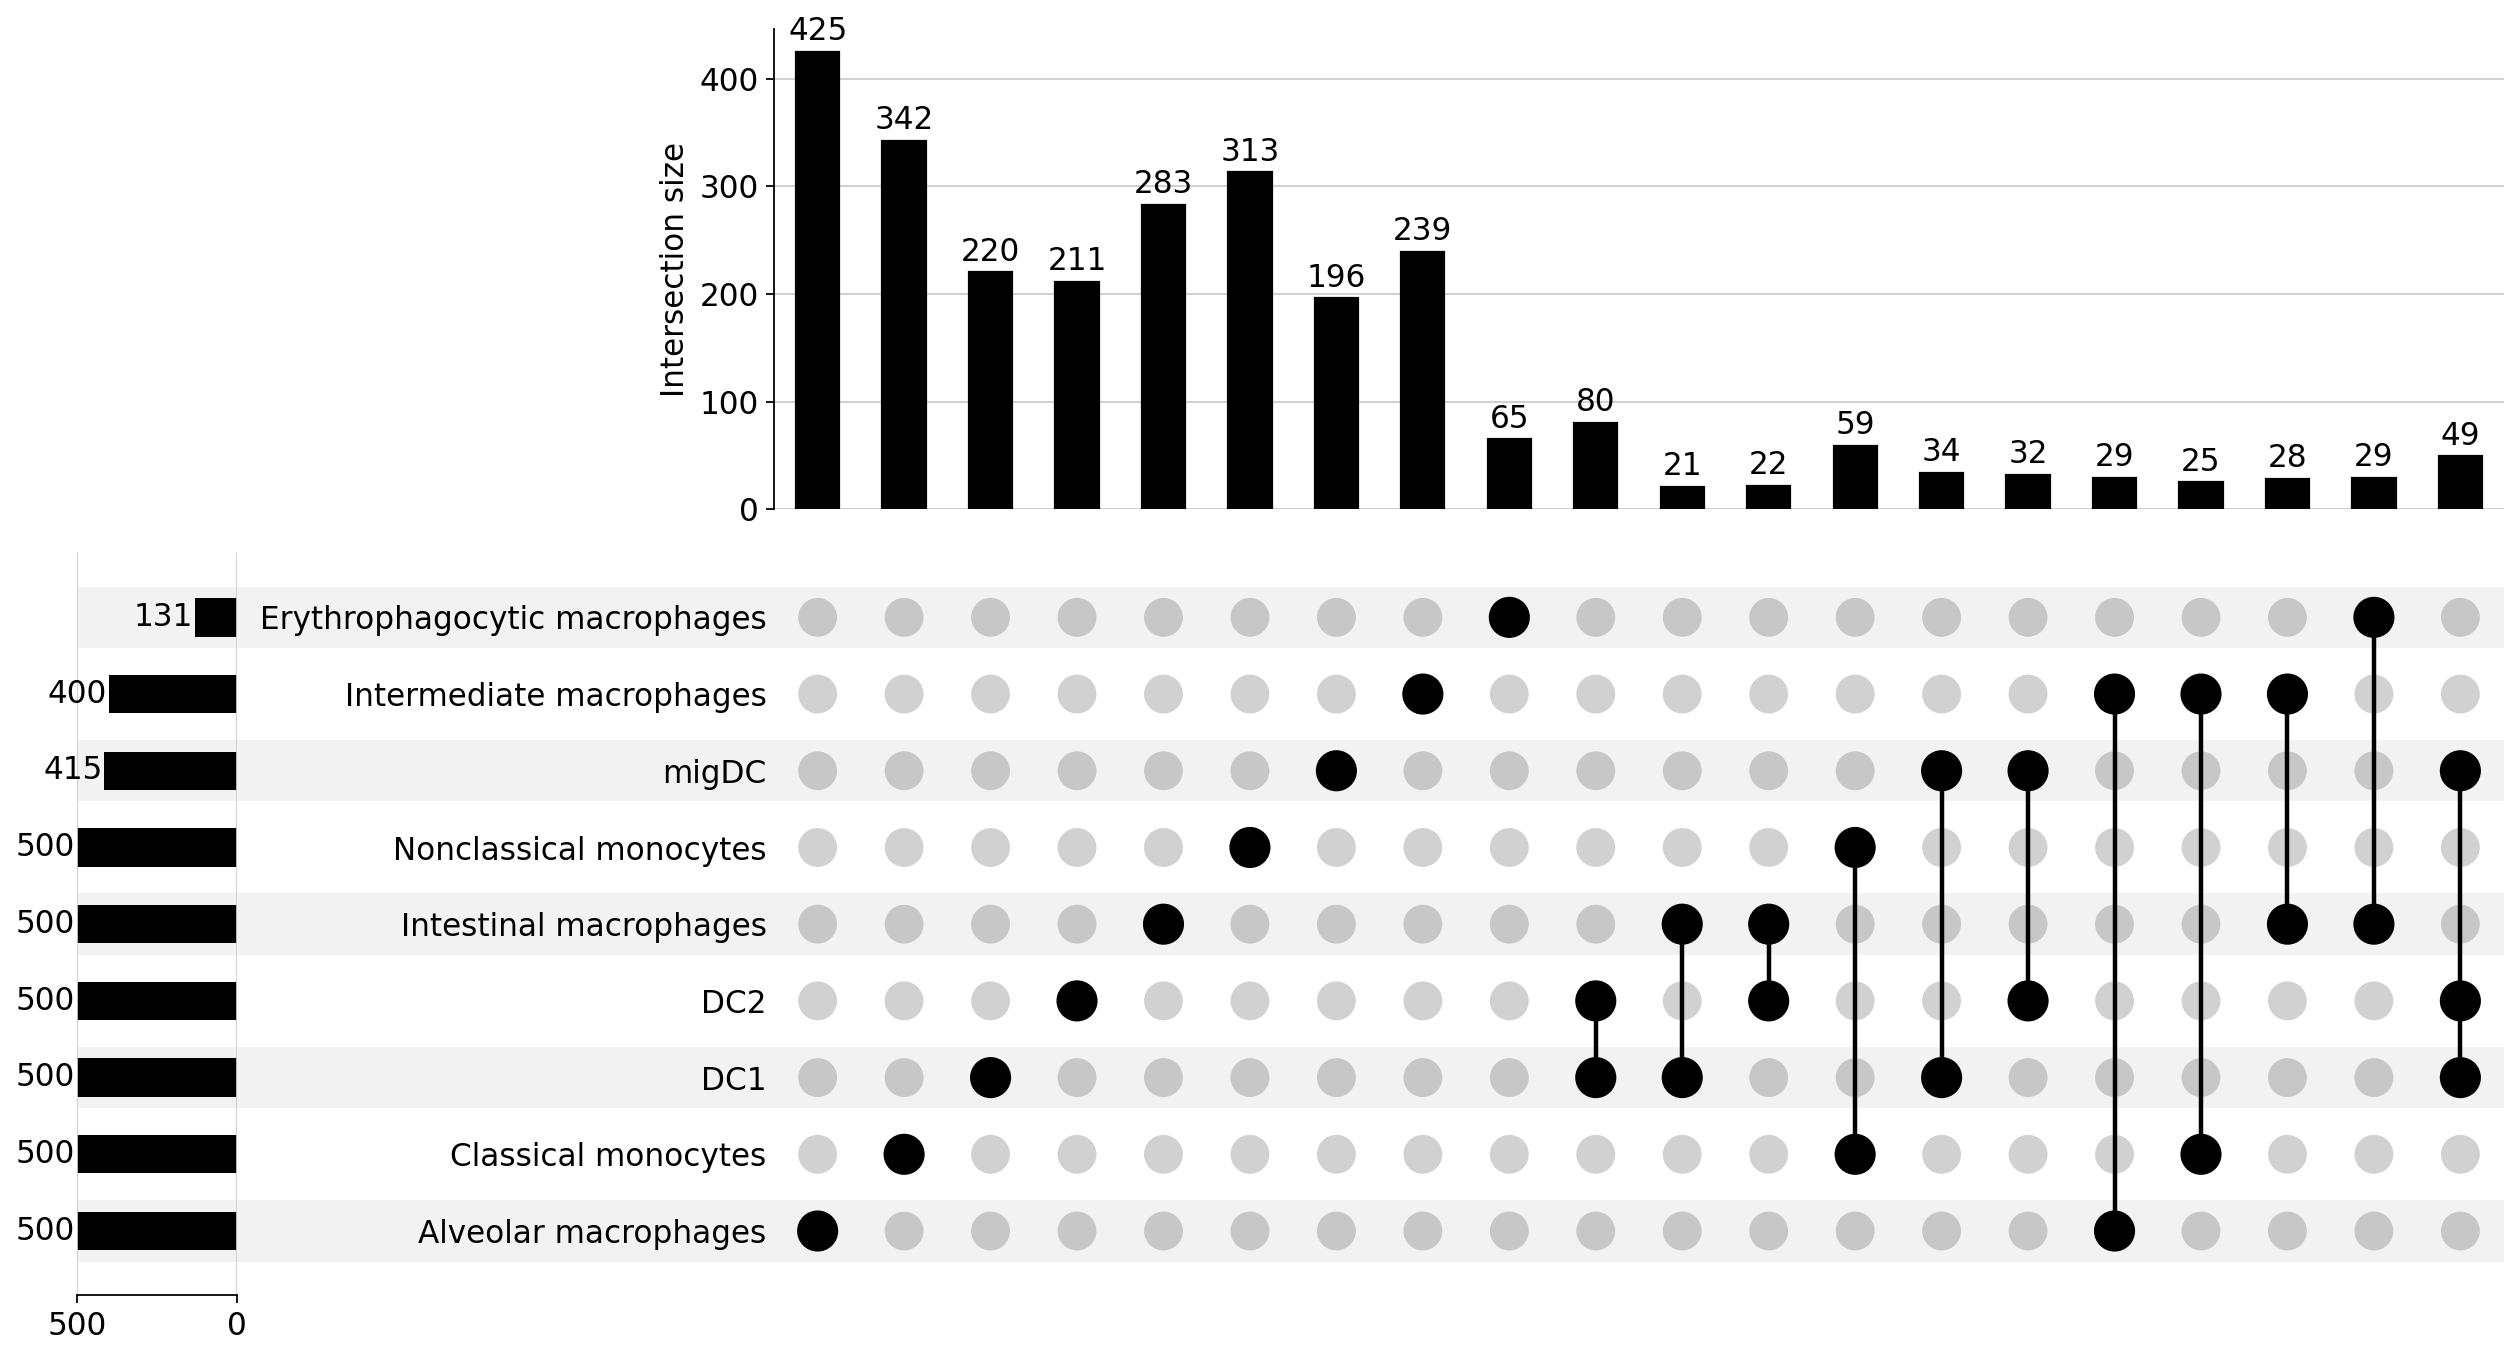

In [17]:
CT_markers = from_contents(Dict_markers)

plt = UpSet(CT_markers, min_subset_size=20, subset_size='count',element_size=50,  show_counts=True).plot()

In [18]:
Dict_markers['Intestinal macrophages'].loc[0:3]

0    ENSG00000250722
1    ENSG00000017427
2    ENSG00000253988
3    ENSG00000090659
Name: names, dtype: object

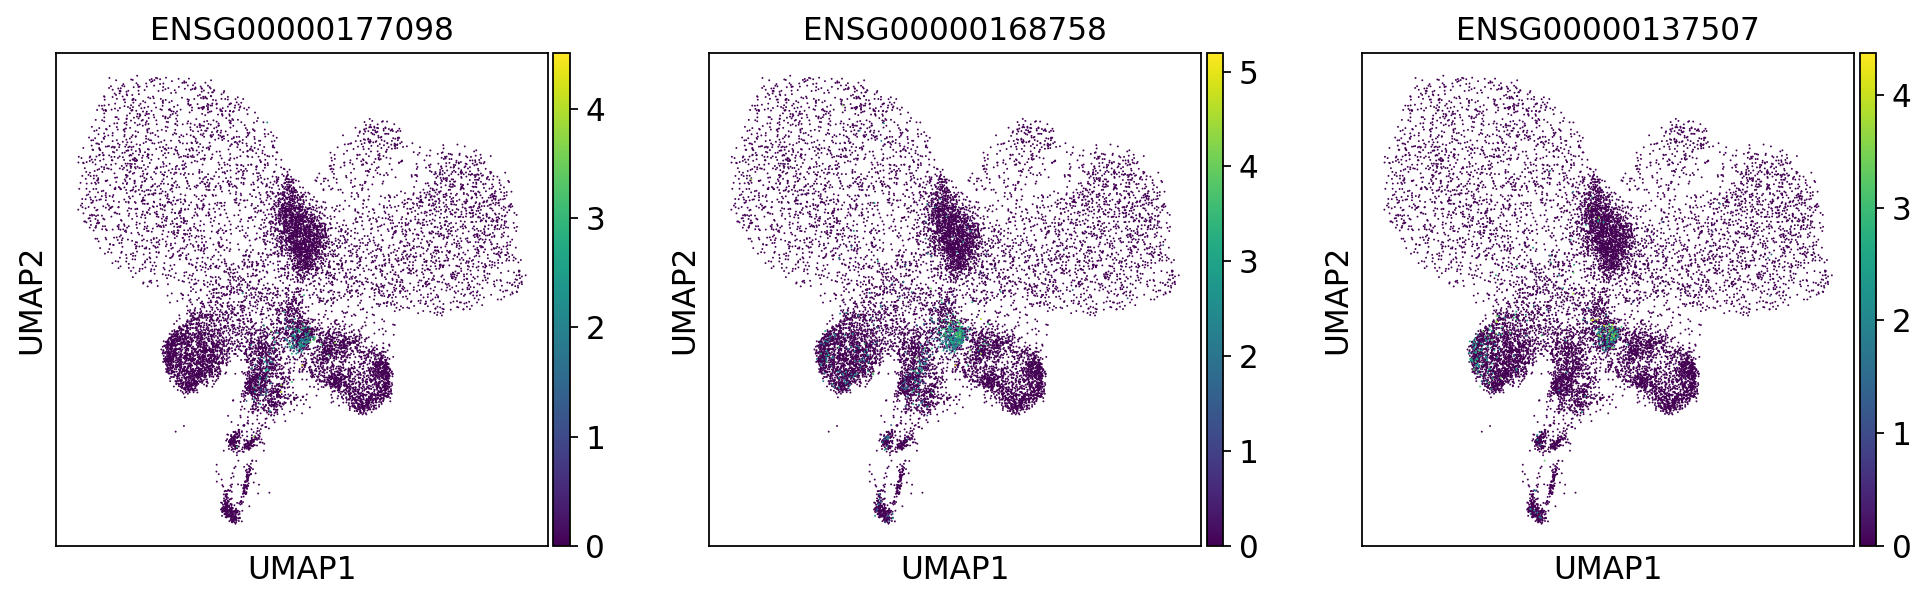

In [19]:
sc.pl.umap(adata, color= ["ENSG00000177098", "ENSG00000168758","ENSG00000137507"], size= 3  ) # top

In [20]:
## Calling DataFrame constructor after zipping
## both lists, with columns specified
#df = pd.DataFrame(list(zip(Sets[0],  Sets[2], Sets[3])),
#                  columns =[Subtypes[0], Subtypes[2], Subtypes[3]])
#
##df.columns = ['MAC_ALVEOLAR', 'MAC_INTERM','MAC_INTEST']
#
#MAC_ERY_PHAG_df = pd.DataFrame(list(zip(Sets[1])),columns =[Subtypes[1]])
#MAC_ERY_PHAG_df.columns = ['Erythrophagocytic_macrophages']
#

In [21]:
#df

In [22]:
# pip install rpy2
# enables the %%R magic, not necessary if you've already done this
%load_ext rpy2.ipython

In [23]:
#%%R -i df -w 5 -h 5 --units in -r 200
## import df from global environment
## make default figure size 5 by 5 inches with 200 dpi resolution
#library("EnsDb.Hsapiens.v86")
#
#head(df)

In [40]:
%%R

library(stringr)
dim(df)
genelists <- colnames(df)
path <- "~/Desktop/Github/Immune_Adaptation_Atlas/adult_tissues/ENS_genelists_wilcox/MACs/"

for (i in genelists)
    {
    goi <- df[,i]
#    #print(i)
    f <- str_replace_all(i, " ", "_")
    #f <- str_remove_all(f, "[()]")
    print(f)
#    ens_df <- ensembldb::select(EnsDb.Hsapiens.v86, keys= goi, 
#                              keytype = "SYMBOL", 
#                              columns = c("SYMBOL","GENEID"))
#   
#    ens_df <- ens_df$GENEID[grepl(pattern = "^ENS", x = ens_df$GENEID)]
#    #print(head(ens_df)) 
#
#    write(x = ens_df, file = paste0(path, f ,"_ENSEMBL.txt"),ncolumns = 1)
    write(x = goi, file = paste0(path, f ,"_ENSEMBL.txt"),ncolumns = 1)
    }

[1] "Alveolar_macrophages"
[1] "Intermediate_macrophages"
[1] "Intestinal_macrophages"


In [42]:
%%R -i MAC_ERY_PHAG_df
# import df from global environment
head(MAC_ERY_PHAG_df)

goi <- MAC_ERY_PHAG_df[,1]
f <- colnames(MAC_ERY_PHAG_df) 
print(f)
write(x = goi, file = paste0(path, f,"_ENSEMBL.txt"),ncolumns = 1)

[1] "Erythrophagocytic_macrophages"


## Export full list of marker genes

In [24]:
full_csv_path = '/home/irepan/Desktop/Github/Immune_Adaptation_Atlas/adult_tissues/ENS_FULL_genelists_wilcox/Myeloid_ALL/full.csv'

(pd.DataFrame.from_dict(data=CompleteDict_markers, orient='index')
   .to_csv(full_csv_path, header=False))

In [25]:
%%R -i full_csv_path
#library("EnsDb.Hsapiens.v86")
library(stringr)

path <- "~/Desktop/Github/Immune_Adaptation_Atlas/adult_tissues/ENS_FULL_genelists_wilcox/Myeloid_ALL/"

mycsv <- read.csv(full_csv_path, row.names = 1,header = F, na.strings = "")

for (i in 1:nrow(mycsv))
{
    genelist <- row.names(mycsv)[i]
    n <- sum(!is.na(mycsv[i,]))
    #print(paste0(n," genes"))
    
    goi <- as.character(mycsv[i,1:n])
    print(goi[1:5])

    f <- str_replace_all(genelist, " ", "_")
    f <- str_remove_all(f, "[()]")
    print(f)
#    ens_df <- ensembldb::select(EnsDb.Hsapiens.v86, keys= goi, 
#                              keytype = "SYMBOL", 
#                              columns = c("SYMBOL","GENEID"))
#   
#    ens_df <- ens_df$GENEID[grepl(pattern = "^ENS", x = ens_df$GENEID)]
#    #print(head(ens_df)) 
#
#    write(x = ens_df, file = paste0(path, f ,"_FULL_ENSEMBL.txt"),ncolumns = 1)
    write(x = goi, file = paste0(path, f ,"_FULL_ENSEMBL.txt"),ncolumns = 1)

}


[1] "ENSG00000258826" "ENSG00000115648" "ENSG00000241213" "ENSG00000135917"
[5] "ENSG00000167588"
[1] "Alveolar_macrophages"
[1] "ENSG00000163221" "ENSG00000143546" "ENSG00000163220" "ENSG00000242550"
[5] "ENSG00000186205"
[1] "Classical_monocytes"
[1] "ENSG00000197992" "ENSG00000108849" "ENSG00000173578" "ENSG00000177459"
[5] "ENSG00000259289"
[1] "DC1"
[1] "ENSG00000179639" "ENSG00000116031" "ENSG00000124780" "ENSG00000158481"
[5] "ENSG00000105492"
[1] "DC2"
[1] "ENSG00000073754" "ENSG00000250722" "ENSG00000166211" "ENSG00000138449"
[5] "ENSG00000162692"
[1] "Erythrophagocytic_macrophages"
[1] "ENSG00000108691" "ENSG00000108688" "ENSG00000225107" "ENSG00000275302"
[5] "ENSG00000118785"
[1] "Intermediate_macrophages"
[1] "ENSG00000250722" "ENSG00000017427" "ENSG00000253988" "ENSG00000090659"
[5] "ENSG00000135094"
[1] "Intestinal_macrophages"
[1] "ENSG00000197353" "ENSG00000106341" "ENSG00000287682" "ENSG00000148344"
[5] "ENSG00000233392"
[1] "Nonclassical_monocytes"
[1] "ENSG000002492